<a href="https://colab.research.google.com/github/mastermindankur/stock-analysis/blob/main/Support_Resistance_SK_Anku_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
!pip install bsedata
!pip install quandl

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as dates
import quandl
%matplotlib inline

In [98]:
# to be ale to view numbers in human readable format 2.058691e+08
#izbxGLp_K_zzzUJdN9sp
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [99]:
quandl.ApiConfig.api_key = 'izbxGLp_K_zzzUJdN9sp'

In [100]:
sbi =quandl.get('BSE/BOM500112', start_date='2021-01-01', end_date='2021-03-14')

**Pivot Point Calculation**

Pivot point (PP) = (High + Low + Close) / 3.

First resistance (R1) = (2 x PP) – Low.

First support (S1) = (2 x PP) – High.

Second resistance (R2) = PP + (High – Low)

Second support (S2) = PP – (High – Low)

Third resistance (R3) = High + 2(PP – Low)

Third support (S3) = Low – 2(High – PP)

In [101]:
sbi['PP']= (sbi['High']+sbi['Low']+sbi['Close'])/3
sbi['R1']= 2*sbi['PP'] -sbi['Low']
sbi['S1']= 2*sbi['PP'] -sbi['High']
sbi['R2']= sbi['PP'] + (sbi['High'] - sbi['Low']) 
sbi['S2']= sbi['PP'] - (sbi['High'] - sbi['Low']) 
sbi['R3']= sbi['High'] + 2*(sbi['PP'] - sbi['Low'])
sbi['S3']= sbi['Low'] - 2*(sbi['High'] - sbi['PP'])

In [102]:
#No of shares worth 50,000 Rupees
# Up and Down are the ticks above and below which we want to execute trade
no_of_shares=50000/sbi['Open'].median()
up= sbi['Spread H-L'].median()*.10
down= sbi['Spread H-L'].median() *.10
#up=1
#down=1

**I will set the Target price in such a way, that i am will buy above the Support and will want to sell it below the Resistance**

In [103]:
sbi['Buy']= sbi['S1'].shift(1) + up
sbi['Sell']= sbi['R1'].shift(1) - down

In [104]:
#sbi[['Open','High','Low','Close','PP','S1','R1','Buy','Sell']].head()

The following Flags are set for 'got_it':

**1** - If we are able to Buy at Support+delta and Sell at Resistance-delta the same day. Successful Trade.

**2** - If we are able to Buy at Support+delta but not able to sell it since the Resistance-delta price never came.

**0** - If we are not able to buy at all since Support+delta price was never reached that day

In [105]:
#sbi['got_it']=(sbi['Buy']>sbi['Low']) & (sbi['Sell'] <sbi['High']) & (sbi['Sell']>sbi['Buy'])
# Set initial value set to 0 of all elements
sbi['got_it'] = 0

# if the trade happened between support and resistance levels, put 1 in got_it column
sbi.loc[(sbi['Buy']>sbi['Low']) & (sbi['Sell'] <sbi['High']) & (sbi['Sell']>sbi['Buy']),'got_it']=1

# If i was able to Buy but not able to sell it becuase price did not hit resistance level, put 2 in got_it column
sbi.loc[(sbi['Buy']>sbi['Low']) & (sbi['Sell'] >sbi['High']) ,'got_it']=2

When Resistance Level was hit the same day and trade happened successfully:

**Profit = Selling Price  - Buying Price**

However, when Resitance price did not hit, we are forcing to sell at Closing Price for that day. In that case:

**Profit = Closing Price - Buying Price**

In [106]:
#df['color'] = np.where(df['Set']=='Z', 'green', 'red')
sbi['Profit']=0
profit= sbi['Sell']-sbi['Buy']
forced_profit_or_loss= sbi['Close']-sbi['Buy']

sbi.loc[(sbi['got_it']==1) ,'Profit']=profit
sbi.loc[(sbi['got_it']==2) ,'Profit']=forced_profit_or_loss
#sbi['Profit'] = np.where(sbi['got_it']==1, profit, 0)
#sbi['Profit'] = np.where(sbi['got_it']==2, forced_profit_or_loss, 0)

In [119]:
sbi['got_it'].value_counts()

0    25
2    12
1    12
Name: got_it, dtype: int64

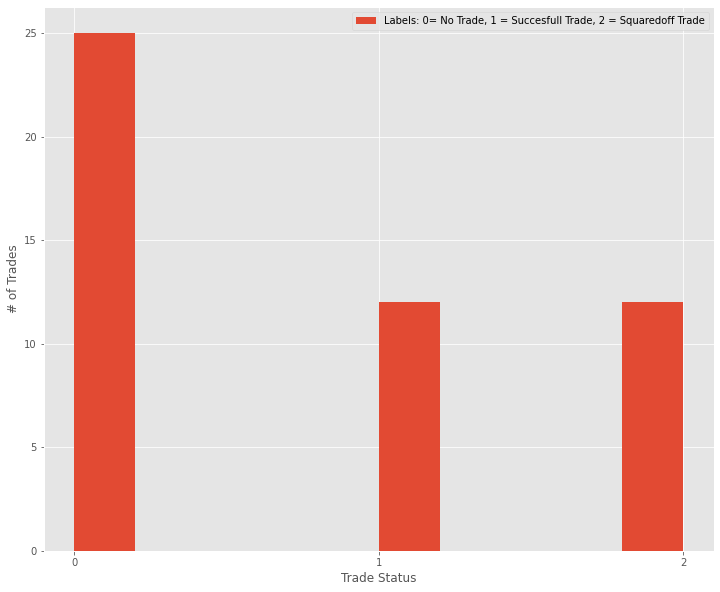

In [108]:
sbi['got_it'].plot.hist(label='Labels: 0= No Trade, 1 = Succesfull Trade, 2 = Squaredoff Trade', figsize=(12,10))
plt.ylabel('# of Trades')
plt.xlabel('Trade Status')
plt.xticks([0,1,2])
plt.style.use('ggplot')
plt.legend()

**Calculating the Profit for the following 3 scenarios:**

1 - If we are able to Buy at Support+delta and Sell at Resistance-delta the same day. Successful Trade.

2 - If we are able to Buy at Support+delta but not able to sell it since the Resistance-delta price never came.

TOTAL PROFIT

In [109]:
sbi[sbi['got_it']==2]['Profit'].sum()

-45.949999999999875

In [110]:
sbi[sbi['got_it']==1]['Profit'].sum()

62.150000000000546

In [111]:
sbi['Profit'].sum()

16.20000000000067

If we had executed every trade worth 50,000 Rs, How much we would have made?

In [112]:
sbi['Profit'].sum() * no_of_shares

2098.4455958550093

Calculating the **Percentage Return**

Return = Profit/ Average Price * 100

In [113]:
sbi['Open'].mean()

347.5357142857142

In [114]:
x=sbi['Profit'].sum()/sbi['Open'].mean() *100
print("The profit percentage you can get is {rate}".format(rate=x))

The profit percentage you can get is 4.661391429452459


**Plotting Some Charts**

In [115]:
sbi[['Open','High','Low','Close','PP','S1','R1','Buy','Sell','got_it','Profit']].tail(10)

,Open,High,Low,Close,PP,S1,R1,Buy,Sell,got_it,Profit
Date,,,,,,,,,,,
2021-02-26,400.400,401.050,387.000,390.200,392.750,384.450,398.500,405.542,411.292,2,-15.342
2021-03-01,395.800,397.700,391.000,395.000,394.567,391.433,398.133,385.725,397.225,0,0.000
2021-03-02,395.700,399.500,390.600,393.950,394.683,389.867,398.767,392.708,396.858,1,4.150
2021-03-03,396.700,408.900,395.600,405.050,403.183,397.467,410.767,391.142,397.492,0,0.000
2021-03-04,399.800,403.450,394.600,395.800,397.950,392.450,401.300,398.742,409.492,2,-2.942
2021-03-05,395.000,395.000,378.200,383.800,385.667,376.333,393.133,393.725,400.025,2,-9.925
2021-03-08,388.600,393.400,386.400,389.550,389.783,386.167,393.167,377.608,391.858,0,0.000
2021-03-09,393.050,394.800,382.350,387.500,388.217,381.633,394.083,387.442,391.892,1,4.450
2021-03-10,391.400,392.800,385.700,387.500,388.667,384.533,391.633,382.908,392.808,0,0.000


In [116]:
sbi[['Open','High','Low','Close','PP','S1','R1','Buy','Sell','got_it','Profit']].to_excel('Stock.xlsx',sheet_name='xx')

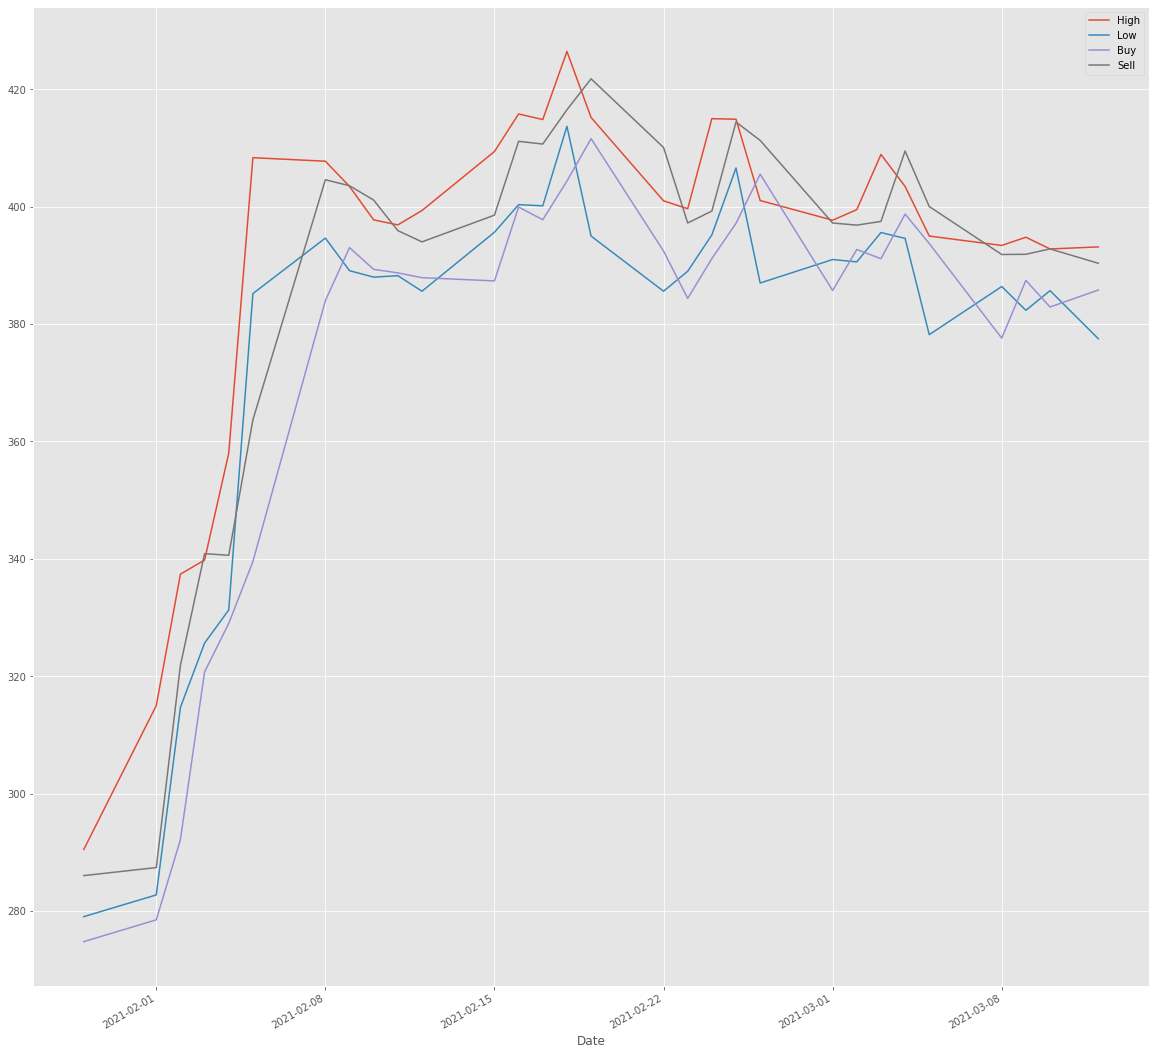

In [120]:
sbi[['High','Low','Buy','Sell']].tail(30).plot(figsize=(20,20))

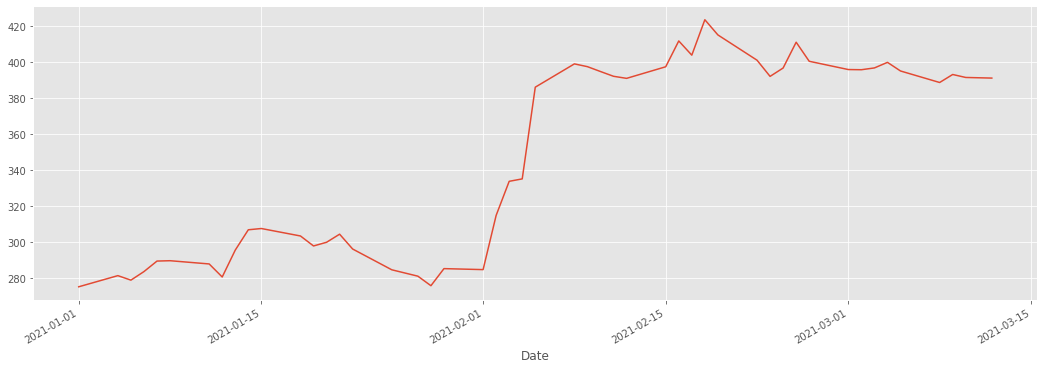

In [118]:
sbi['Open'].plot(figsize=(18,6))